In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.pyplot import figure
from matplotlib.patches import Rectangle
from IPython.display import display
import stumpy
import os
import zipfile
from tqdm.notebook import tqdm_notebook
from datetime import datetime

np.set_printoptions(suppress=True)

data_directory = './data/Feb2022/' # The root directory for where all the data files are stored
overall_filename = 'february_data.csv' # Filename where the concatenated individual files will be stored

In [93]:
# Helper functions. They do what the function name suggests

def read_in_file(filename, keep_columns=None, time_format='%Y-%m-%dT%H:%M:%S.%f'):
    '''Reads in a .csv file into a Pandas DataFrame. 
    
    This function assumes there is a column in the .csv whose name is 'time'. The 'time' column is automatically set as a
    Pandas DatetimeIndex.

    Args:
        filename : str
            The name of the file to be read from, in .csv format.
        keep_columns : list str
            The names of the columns to keep from the file. If None, all columns will be kept.
        drop_columns: list str
            The names of the columns to drop from the file. If None, it will not be used.
        time_format: str
            The datetime format for which to parse the 'time' column from the .csv file. 

    Returns:
        A Pandas DataFrame.
    '''
    df = pd.read_csv(filename, usecols=keep_columns)

    if 'time' in df.columns.tolist():
        df.time = pd.to_datetime(df.time, format=time_format)
        df = df.set_index('time')

    return df

def groupby_second(df, agg='mean'):
    '''Groups a Pandas DataFrame by second according to the aggregation method agg.

    Args:
        df: Pandas DataFrame
            A Pandas DataFrame whose index is a DatetimeIndex. The index needs to be of this type to perform the groupby.
        agg: str
            The aggregation method for the groupby operation. Default is 'mean'.

    Returns:
        The resulting Pandas DataFrame.
    '''
    df = df.groupby(by=[df.index.year, df.index.month, df.index.day, df.index.hour, df.index.minute, df.index.second]).agg(agg)
    df.index = pd.to_datetime(df.index.get_level_values(0).astype(str) + '-' +
                df.index.get_level_values(1).astype(str) + '-' +
                df.index.get_level_values(2).astype(str) + 'T' +
                df.index.get_level_values(3).astype(str) + ':' +
                df.index.get_level_values(4).astype(str) + ':' +
                df.index.get_level_values(5).astype(str),
                format='%Y-%m-%dT%H:%M:%S')
    return df

def do_matrix_profile_nd(df, m, do_gpu_stump=False, fontsize=14,
                         save_fig=False, fname=None):
    '''Performs an n-dimensional matrix profile to find motifs, where n > 1.
    
    This function will display PyPlot figures for each dimension of the matrix profile. If the parameter do_gpu_stump
    is set to True, this function will perform the matrix profile on a GPU. While this operation can be sped up by
    using a GPU, it requires the GPU to be a properly configured NVIDIA GPU. See the Stumpy library documentation for 
    more details.
    
    Args:
        df: Pandas DataFrame
            A Pandas DataFrame with more than one column and whose number of columns is greater than 1. Additionally,
            each column of the DataFrame needs to be of type float. This function will not work with non-continuos
            datatypes present in the DataFrame.
        m: int
            The window size for the matrix profile.
        do_gpu_stump: bool
            Determines whether or not to run the matrix profile using a properly configured NVIDIA GPU.
            
    Returns:
        None. Only the output is displayed.
    '''

    if not do_gpu_stump:
        mps, indices = stumpy.mstump(df, m)
    else:
        mps, indices = stumpy.gpu_mstump(df, m) # I'm not sure if this is the right function to call. There is a stumped function for distributed CPU processing.
    
    motifs_idx = np.argsort(mps, axis=1)[:, 0]
    motifs_nn_idx = indices[np.arange(len(motifs_idx)), motifs_idx]

    discords_idx = np.argsort(mps, axis=1)[:, -1]
    discord_nn_idx = indices[np.arange(len(discords_idx)), discords_idx]

    fig, axs = plt.subplots(mps.shape[0] * 2, sharex=True, gridspec_kw={'hspace': 0}, figsize=(18,5*df.shape[1]))

    for k, dim_name in enumerate(df.columns):
        axs[k].set_ylabel(dim_name, fontsize=fontsize)
        axs[k].plot(np.arange(df.shape[0]), df[dim_name])
        axs[k].set_xlabel('Time', fontsize =fontsize)

        axs[k + mps.shape[0]].set_ylabel(dim_name.replace('T', 'P'), fontsize=fontsize)
        axs[k + mps.shape[0]].plot(mps[k], c='orange')
        axs[k + mps.shape[0]].set_xlabel('Time', fontsize =fontsize)

        # axs[k].axvline(x=motifs_idx[1], linestyle="dashed", c='black')
        # axs[k].axvline(x=motifs_nn_idx[1], linestyle="dashed", c='black')
        # axs[k + mps.shape[0]].axvline(x=motifs_idx[1], linestyle="dashed", c='black')
        # axs[k + mps.shape[0]].axvline(x=motifs_nn_idx[1], linestyle="dashed", c='black')

        # if dim_name != 'T3':
        #     axs[k].plot(range(motifs_idx[k], motifs_idx[k] + m), df[dim_name].iloc[motifs_idx[k] : motifs_idx[k] + m], c='red', linewidth=4)
        #     axs[k].plot(range(motifs_nn_idx[k], motifs_nn_idx[k] + m), df[dim_name].iloc[motifs_nn_idx[k] : motifs_nn_idx[k] + m], c='red', linewidth=4)
        #     axs[k + mps.shape[0]].plot(motifs_idx[k], mps[k, motifs_idx[k]] + 1, marker="v", markersize=10, color='red')
        #     axs[k + mps.shape[0]].plot(motifs_nn_idx[k], mps[k, motifs_nn_idx[k]] + 1, marker="v", markersize=10, color='red')
        # else:
        #     axs[k + mps.shape[0]].plot(motifs_idx[k], mps[k, motifs_idx[k]] + 1, marker="v", markersize=10, color='black')
        #     axs[k + mps.shape[0]].plot(motifs_nn_idx[k], mps[k, motifs_nn_idx[k]] + 1, marker="v", markersize=10, color='black')

    if save_fig:
        plt.tight_layout()
        plt.savefig(fname, dpi=300)

    plt.show()

def do_matrix_profile_1d(df, m, do_gpu_stump=False, fontsize=14,
                         save_fig=False, fname=None):
    '''Performs an 1-dimensional matrix profile to find motifs and discords.
    
    This function will display a PyPlot figure for the matrix profile. If the parameter do_gpu_stump
    is set to True, this function will perform the matrix profile on a GPU. While this operation can be sped up by
    using a GPU, it requires the GPU to be a properly configured NVIDIA GPU. See the Stumpy library documentation for 
    more details.
    
    Args:
        df: Pandas DataFrame
            A Pandas DataFrame with exactly one column. Additionally, that column of the DataFrame needs to be of type
            float. This function will not work with non-continuos datatypes present in the DataFrame.
        m: int
            The window size for the matrix profile.
        do_gpu_stump: bool
            Determines whether or not to run the matrix profile using a properly configured NVIDIA GPU.
            
    Returns:
        None. Only the output is displayed.
    '''
    if not do_gpu_stump:
        mp = stumpy.stump(df.iloc[:, 0], m)
    else:
        mp = stumpy.gpu_stump(df.iloc[:, 0], m)

    # Create the axis
    fig, axs = plt.subplots(2, sharex=True, sharey=False, gridspec_kw={'hspace': 0}, figsize=(18,10))
    plt.suptitle('Discord (Anomaly/Novelty) Discovery - Window Size {}'.format(m), fontsize=fontsize)
    axs[0].plot(df.iloc[:, 0].values)
    axs[0].set_ylabel(list(df.columns)[0], fontsize=fontsize)
    axs[1].set_xlabel('Time', fontsize =fontsize)
    axs[1].set_ylabel('Matrix Profile', fontsize=fontsize)
    axs[1].plot(mp[:, 0])

    # Find and plot motifs
    motif_idx = np.argsort(mp[:, 0])[0]
    nearest_neighbor_idx = mp[motif_idx, 1]
    
    rect = Rectangle((motif_idx, 0), m, max(df.iloc[:, 0]), facecolor='lightgrey')
    axs[0].add_patch(rect)
    rect = Rectangle((nearest_neighbor_idx, 0), m, max(df.iloc[:, 0]), facecolor='lightgrey')
    axs[0].add_patch(rect)
    axs[1].axvline(x=motif_idx, linestyle="dashed", color='grey')
    axs[1].axvline(x=nearest_neighbor_idx, linestyle="dashed", color='grey')


    # Find and plot the discords
    discord_idx = np.argsort(mp[:, 0])[-1]

    rect = Rectangle((discord_idx, 0), m, max(df.iloc[:, 0]), facecolor='red', alpha=.35)
    axs[0].add_patch(rect)
    axs[1].axvline(x=discord_idx, linestyle="dashed", color='red', alpha=0.5)

    if save_fig:
        plt.tight_layout()
        plt.savefig(fname, dpi=300)

    plt.show()

def do_matrix_profile(df, m, t1=None, t2=None, impute=False, fontsize=14,
                      save_fig=False, fname=None):
    '''Performs a matrix profile on the given data df between the time intervals t1 and t2.
    
    This function will infer whether to run a 1-dimensional or n-dimensional matrix profile based
    on the number of columns in df. The use of t1 and t2 Datetime objects makes it intuitive to
    perform this operation for a given time window, e.g., the user can choose to plot only those
    data points belonging to February 18th, 2022.
    
    Args:
        df: Pandas DataFrame
            Contains the data to which the matrix profile will be performed. This DataFrame needs to
            have a DatetimeIndex to work.
        m: int
            The window size for the matrix profile.
        t1: Datetime
            The opening of the time interval (inclusive).
        t2: Datetime
            The end of the time interval (exclusive).
    Returns:
        None
    '''

    if t1 is not None \
        and t2 is not None \
        and t1 < t2:
        df = df[(df.index >= t1) & (df.index < t2)]

    if impute:
        if df.isnull().values.any():
            df.fillna(df.mean())

    if len(df.columns) > 1: # If you have more than one dimension
        do_matrix_profile_nd(df, m, fontsize=fontsize, save_fig=save_fig, fname=fname)
    else:
        do_matrix_profile_1d(df, m, fontsize=fontsize, save_fig=save_fig, fname=fname)


def plot_time_window(df, t1, t2, col, impute=False, title=None, fontsize=14,
                     save_fig=False, fname=None):
    '''Plots one column of a DataFrame in a certain time window.
    
    Args:
        df: Pandas DataFrame
            The DataFrame with the data to be plotted.
        t1: Datetime
            The opening of the time interval (inclusive).
        t2: Datetime
            The end of the time interval (exclusive).
        col: str
            The column of df to plot.
        impute: bool
            Determines whether or not to impute missing values with the mean.'''
    df = df[(df.index >= t1) & (df.index < t2)]

    if impute:
        if df.isnull().values.any():
            df.fillna(df.mean())

    sns.lineplot(x=df.index, y=df[col])
    plt.rcParams.update({'font.size': fontsize})
    if title is not None:
        plt.title(title, fontsize=fontsize)

    if save_fig:
        plt.tight_layout()
        plt.savefig(fname, dpi=300)
        
    plt.show()

In [77]:
# Utility class for zipping/unzipping archives

class Zipper():
    def zip_one_file(self, file, archive):
        with zipfile.ZipFile(archive, "w", zipfile.ZIP_DEFLATED) as zf:
            zf.write(file)

    def zip_files(self, files, archives):
        for i, file in enumerate(files):
            self.zip_one_file(file, archives[i])

    def unzip_one_archive(self, archive, out_dir=None):
        with zipfile.ZipFile(archive, 'r') as zf:
            info = zf.infolist()
            file = info[0]
            zf.extract(file, out_dir)

In [5]:
# Run this cell if you need to extract all the data files from data_directory + 'zip/'

archive_directory = data_directory + 'zip/'
out_dir = data_directory

archives = [archive_directory + file for file in os.listdir(archive_directory)]

for archive in archives:
    Zipper().unzip_one_archive(archive, out_dir)

In [8]:
# Run this cell if you need to concatenate all the data files from data_directory into a csv grouped by second

out_file = 'february_data_by_second.csv'
indx_files = list(enumerate(os.listdir(data_directory)))
for i, file in tqdm_notebook( indx_files ): # For each of our february files

    if ".csv" not in file:
        continue
    
    df = read_in_file(data_directory + file)
    df = groupby_second(df)
    df.dropna(inplace=True)

    if len(df) > 0:
        if i == 0:
            df.to_csv(out_file)
        else:
            df.to_csv(out_file, mode='a', header=False)

  0%|          | 0/310 [00:00<?, ?it/s]

In [4]:
# Run this cell if you need to concatenate all the data files from data_directory into a csv

out_file = 'february_data.csv'
indx_files = list(enumerate(os.listdir(data_directory)))
for i, file in tqdm_notebook( indx_files ): # For each of our february files

    if ".csv" not in file:
        continue
    
    df = read_in_file(data_directory + file)

    if len(df) > 0:
        if i == 0:
            df.to_csv(out_file)
        else:
            df.to_csv(out_file, mode='a', header=False)

  0%|          | 0/310 [00:00<?, ?it/s]

In [ ]:
'''
TODO: 
    compare different startup-to-stop windows
    document code
    make poster
'''

Start of Matrix Profile Analysis

In [8]:
# Read in the data from february
src_file = 'february_data.csv'
df_overall = read_in_file(src_file, keep_columns=['time', 'Continuous Bond Vibration'])
df_overall = df_overall.fillna(method='ffill') # Imputes NaNs from the last valid observation

In [10]:
# Groupby second using the RMS function

rms = lambda x: np.sqrt(np.mean(x**2))
df = df_overall.dropna()
df = groupby_second(df, rms) # Trying rms instead of mean or sum
print(df.head())

                     Continuous Bond Vibration
time                                          
2022-02-14 00:00:00                   0.760843
2022-02-14 00:00:01                   0.743628
2022-02-14 00:00:02                   0.690679
2022-02-14 00:00:03                   0.697774
2022-02-14 00:00:04                   0.704064


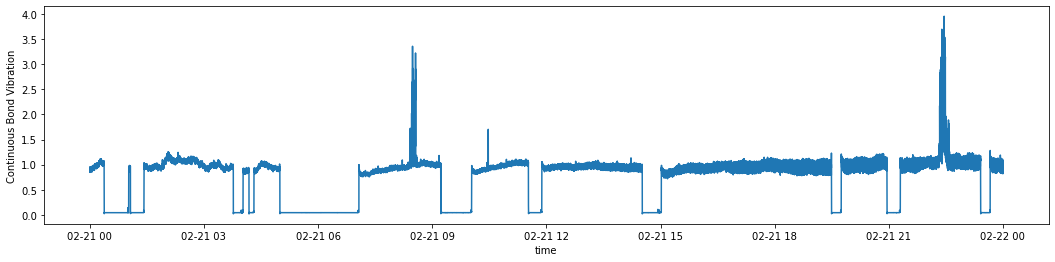

In [16]:
# Set the parameters for later analysis

t1 = datetime(year=2022, 
              month=2, 
              day=21, 
              hour=0, 
              minute=0, 
              second=0)
t2 = datetime(year=2022,
              month=2, 
              day=22, 
              hour=0, 
              minute=0, 
              second=0)

cols = ['Continuous Bond Vibration']

# Plot the time window for some quick EDA
figure(figsize=(18,4))
plot_time_window(df, t1, t2, cols[0], impute=True)

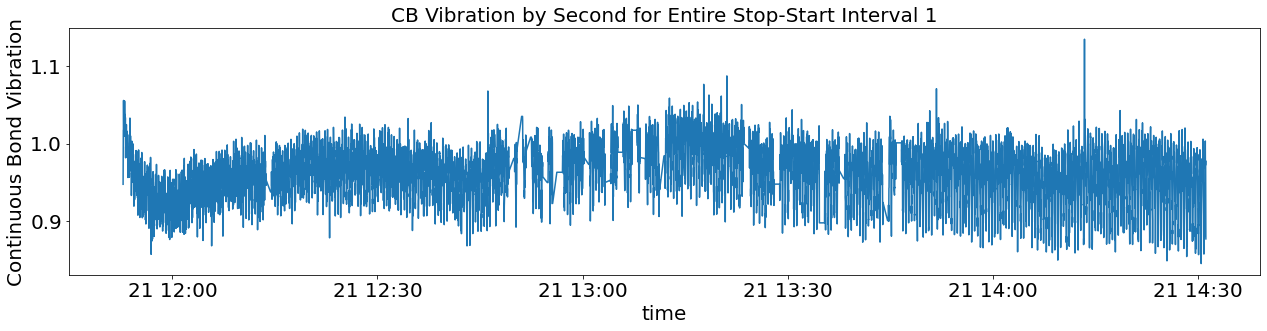

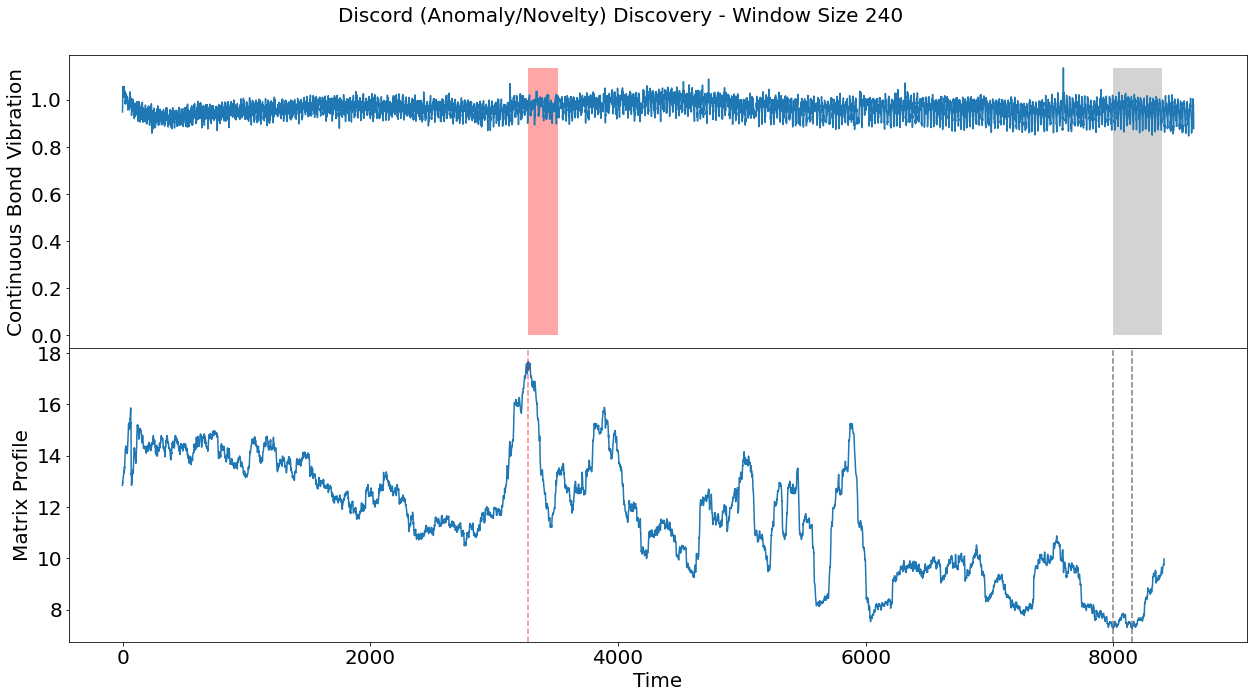

In [94]:
# Set the parameters for later analysis

t1 = datetime(year=2022, 
              month=2, 
              day=21, 
              hour=11, 
              minute=52, 
              second=48)
t2 = datetime(year=2022,
              month=2, 
              day=21, 
              hour=14, 
              minute=31, 
              second=10)

cols = ['Continuous Bond Vibration']
window_sizes = [240] # I chose these windows because it looks like the data runs in regular intervals lasting about 30 sec

# Plot the time window for some quick EDA
figure(figsize=(18,5))
plot_time_window(df, t1, t2, cols[0], impute=True, fontsize=20,
                 title="CB Vibration by Second for Entire Stop-Start Interval 1",
                 save_fig=True, fname="figs/cb-vibr_start-stop-interv_ex-1.png")

# Perform a matrix profile for the different window sizes
for m in window_sizes:
    do_matrix_profile(df[cols], m, t1, t2, impute=True, fontsize=20,
                      save_fig=True, fname="figs/cb-vibr_start-stop-interv_ex-1_mat-prof-240.png")

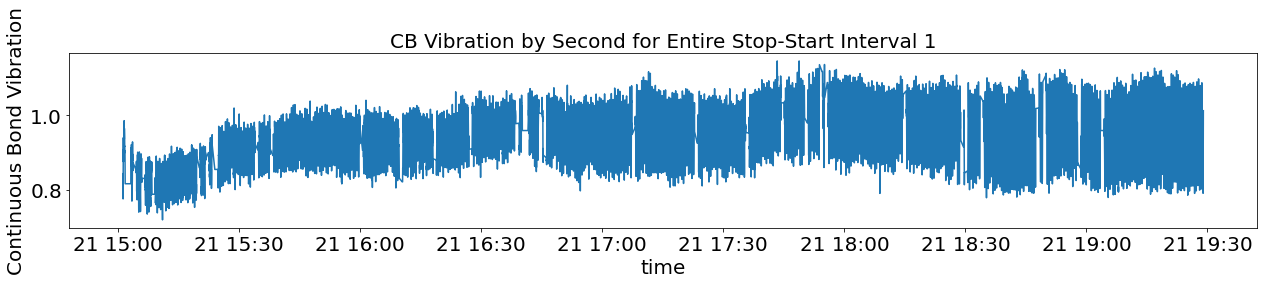

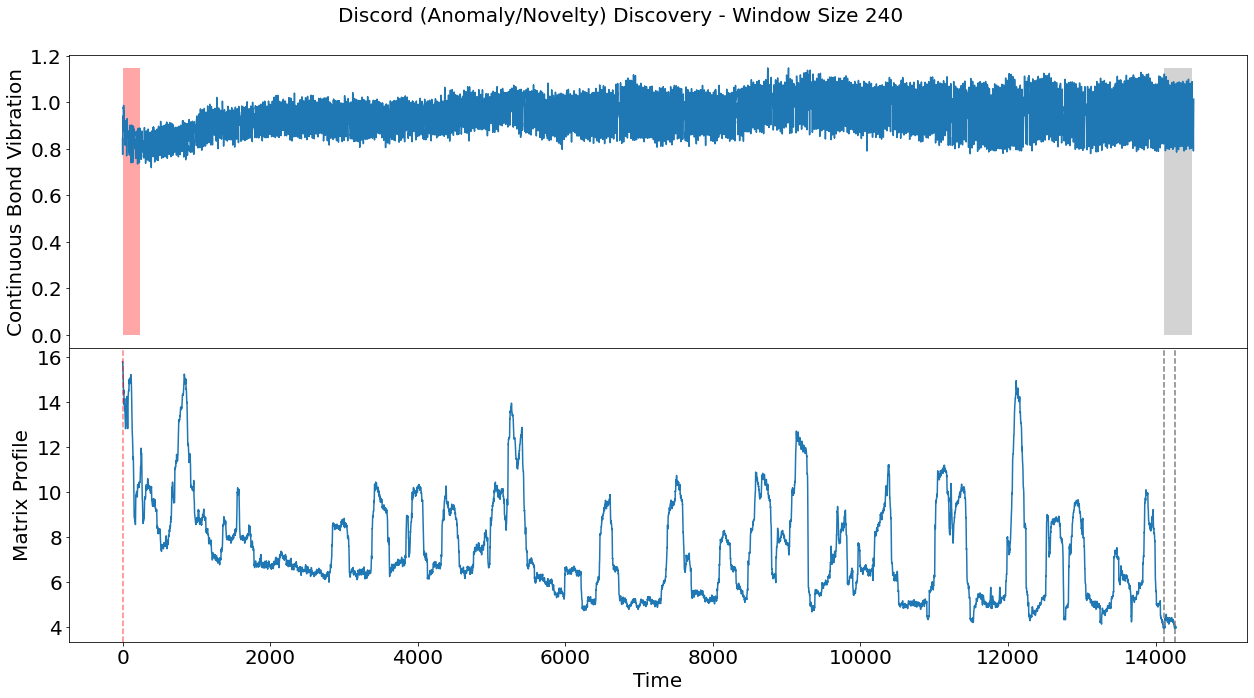

In [95]:
# Set the parameters for later analysis

t1 = datetime(year=2022, 
              month=2, 
              day=21, 
              hour=15, 
              minute=1, 
              second=13)
t2 = datetime(year=2022,
              month=2, 
              day=21, 
              hour=19, 
              minute=29, 
              second=0)

cols = ['Continuous Bond Vibration']
window_sizes = [240] # I chose these windows because it looks like the data runs in regular intervals lasting about 30 sec

# Plot the time window for some quick EDA
figure(figsize=(18,4))
plot_time_window(df, t1, t2, cols[0], impute=True, fontsize=20,
                 title="CB Vibration by Second for Entire Stop-Start Interval 1",
                 save_fig=True, fname="figs/cb-vibr_start-stop-interv_ex-2.png")

# Perform a matrix profile for the different window sizes
for m in window_sizes:
    do_matrix_profile(df[cols], m, t1, t2, impute=True, fontsize=20,
                      save_fig=True, fname="figs/cb-vibr_start-stop-interv_ex-2_mat-prof-240.png")